In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import sklearn

In [3]:
milk_test = pd.read_csv("cattle_data_test.csv")
milk_test.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,...,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis
0,1,Holstein,Temperate,Semi_Intensive,42,420.9,3,Early,302,Mixed_Feed,...,1,0,0,6.76,3.5,12,2022-11-29,FARM_0740,28.4445,0
1,2,Holstein,Temperate,Extensive,112,466.6,5,Late,103,Green_Fodder,...,0,0,1,9.87,2.0,12,2022-10-11,FARM_0607,15.2145,0
2,3,Jersey,Temperate,Semi_Intensive,57,496.5,1,Early,342,Crop_Residues,...,0,1,1,4.27,3.5,12,2024-03-21,FARM_0706,37.4850,0
3,4,Holstein,Subtropical,Extensive,63,617.5,6,Early,170,Concentrates,...,0,1,0,0.00,2.5,12,2023-12-25,FARM_0673,23.1525,0
4,5,Guernsey,Tropical,Semi_Intensive,34,413.9,6,Early,246,Dry_Fodder,...,0,1,1,1.91,3.5,12,2023-05-18,FARM_0112,35.5005,0


In [4]:
#categoricals
breed_data = milk_test['Breed']
climate_data = milk_test['Climate_Zone']
manage_data = milk_test['Management_System']
lactate_data = milk_test['Lactation_Stage']
feed_data = milk_test['Feed_Type']
print(climate_data.value_counts(dropna = False))
print()
print(breed_data.value_counts(dropna = False))
print()
print(manage_data.value_counts(dropna = False))

Climate_Zone
Arid             6817
Temperate        6762
Mediterranean    6632
Tropical         6602
Subtropical      6600
Continental      6587
Name: count, dtype: int64

Breed
Holstein        19926
Jersey           8091
Brown Swiss      5989
Guernsey         5963
Holstien           14
 Brown Swiss       10
Brown Swiss         7
Name: count, dtype: int64

Management_System
Intensive         8103
Mixed             8077
Semi_Intensive    7998
Pastoral          7919
Extensive         7903
Name: count, dtype: int64


In [5]:
print(lactate_data.value_counts(dropna = False))
print()
print(feed_data.value_counts(dropna = False))

Lactation_Stage
Mid      16115
Late     12027
Early    11858
Name: count, dtype: int64

Feed_Type
Concentrates     5052
Hay              5042
Green_Fodder     5021
Dry_Fodder       5012
Crop_Residues    4998
Pasture_Grass    4986
Silage           4964
Mixed_Feed       4925
Name: count, dtype: int64


In [6]:
milk_test['Breed'] = milk_test['Breed'].str.strip()
milk_test['Breed'] = milk_test['Breed'].replace({'Holstien': 'Holstein'})
print(milk_test['Breed'].value_counts())

Breed
Holstein       19940
Jersey          8091
Brown Swiss     6006
Guernsey        5963
Name: count, dtype: int64


In [7]:
print(milk_test.isnull().sum())

Cattle_ID                     0
Breed                         0
Climate_Zone                  0
Management_System             0
Age_Months                    0
Weight_kg                     0
Parity                        0
Lactation_Stage               0
Days_in_Milk                  0
Feed_Type                     0
Feed_Quantity_kg           2015
Feeding_Frequency             0
Water_Intake_L                0
Walking_Distance_km           0
Grazing_Duration_hrs          0
Rumination_Time_hrs           0
Resting_Hours                 0
Ambient_Temperature_C         0
Humidity_percent              0
Housing_Score              1221
FMD_Vaccine                   0
Brucellosis_Vaccine           0
HS_Vaccine                    0
BQ_Vaccine                    0
Anthrax_Vaccine               0
IBR_Vaccine                   0
BVD_Vaccine                   0
Rabies_Vaccine                0
Previous_Week_Avg_Yield       0
Body_Condition_Score          0
Milking_Interval_hrs          0
Date    

In [ ]:
milk_test['Feed_Quantity_kg'] = milk_test.groupby('Feed_Type')['Feed_Quantity_kg'].transform(lambda x: x.fillna(x.median()))
milk_test['Feed_Quantity_lb'] = milk_test.groupby('Feed_Type')['Feed_Quantity_lb'].transform(lambda x: x.fillna(x.median()))

np.int64(0)

In [14]:
milk_test['Housing_Score'] = milk_test['Housing_Score'].transform(lambda x: x.fillna(x.median()))

In [15]:
print(milk_test.isnull().sum())

Cattle_ID                  0
Breed                      0
Climate_Zone               0
Management_System          0
Age_Months                 0
Weight_kg                  0
Parity                     0
Lactation_Stage            0
Days_in_Milk               0
Feed_Type                  0
Feed_Quantity_kg           0
Feeding_Frequency          0
Water_Intake_L             0
Walking_Distance_km        0
Grazing_Duration_hrs       0
Rumination_Time_hrs        0
Resting_Hours              0
Ambient_Temperature_C      0
Humidity_percent           0
Housing_Score              0
FMD_Vaccine                0
Brucellosis_Vaccine        0
HS_Vaccine                 0
BQ_Vaccine                 0
Anthrax_Vaccine            0
IBR_Vaccine                0
BVD_Vaccine                0
Rabies_Vaccine             0
Previous_Week_Avg_Yield    0
Body_Condition_Score       0
Milking_Interval_hrs       0
Date                       0
Farm_ID                    0
Feed_Quantity_lb           0
Mastitis      

In [22]:
milk_test["Date"] = pd.to_datetime(milk_test["Date"])

In [25]:
milk_test["Date"]

0       2022-11-29
1       2022-10-11
2       2024-03-21
3       2023-12-25
4       2023-05-18
           ...    
39995   2023-06-09
39996   2023-08-08
39997   2022-09-25
39998   2024-05-25
39999   2022-01-04
Name: Date, Length: 40000, dtype: datetime64[ns]

In [26]:
milk_test.head()

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,...,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis
0,1,Holstein,Temperate,Semi_Intensive,42,420.9,3,Early,302,Mixed_Feed,...,1,0,0,6.76,3.5,12,2022-11-29,FARM_0740,28.4445,0
1,2,Holstein,Temperate,Extensive,112,466.6,5,Late,103,Green_Fodder,...,0,0,1,9.87,2.0,12,2022-10-11,FARM_0607,15.2145,0
2,3,Jersey,Temperate,Semi_Intensive,57,496.5,1,Early,342,Crop_Residues,...,0,1,1,4.27,3.5,12,2024-03-21,FARM_0706,37.4850,0
3,4,Holstein,Subtropical,Extensive,63,617.5,6,Early,170,Concentrates,...,0,1,0,0.00,2.5,12,2023-12-25,FARM_0673,23.1525,0
4,5,Guernsey,Tropical,Semi_Intensive,34,413.9,6,Early,246,Dry_Fodder,...,0,1,1,1.91,3.5,12,2023-05-18,FARM_0112,35.5005,0


In [28]:
milk_test["Milking_Interval_hrs"].value_counts()

Milking_Interval_hrs
12    27869
8      6106
24     4039
6      1986
Name: count, dtype: int64

In [29]:
milk_test = milk_test.drop("Feed_Quantity_lb", axis=1)

In [44]:
milk_test["Farm_ID"]

0        FARM_0740
1        FARM_0607
2        FARM_0706
3        FARM_0673
4        FARM_0112
           ...    
39995    FARM_0617
39996    FARM_0748
39997    FARM_0054
39998    FARM_0892
39999    FARM_0568
Name: Farm_ID, Length: 40000, dtype: object

In [47]:
numeric_cols = milk_test.select_dtypes(include='number').columns
farm_features = milk_test.groupby("Farm_ID")[numeric_cols].mean()

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
farm_scaled = scaler.fit_transform(farm_features)
kmeans = KMeans(n_clusters=10, random_state=42)
farm_features['Cluster'] = kmeans.fit_predict(farm_scaled)
# Map back to main dataset
milk_test['Farm_Cluster'] = milk_test['Farm_ID'].map(farm_features['Cluster'])

In [49]:
milk_test['Farm_Cluster'].value_counts()

Farm_Cluster
0    4735
3    4722
4    4560
1    4062
6    3910
2    3894
5    3843
9    3587
7    3383
8    3304
Name: count, dtype: int64

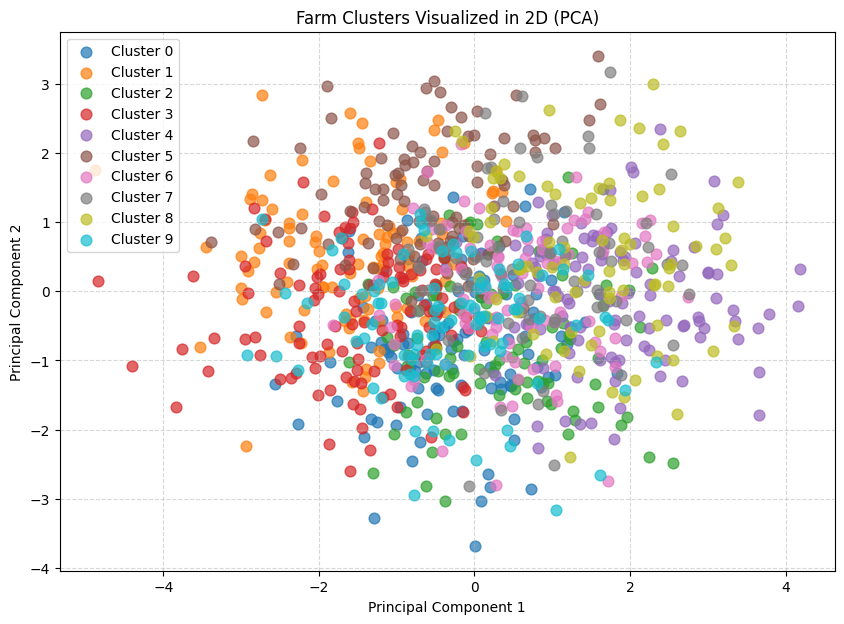

In [50]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assume farm_features has numeric columns and 'Cluster' column
numeric_cols = farm_features.select_dtypes(include='number').columns.drop('Cluster')
# Standardize features
scaler = StandardScaler()
farm_scaled = scaler.fit_transform(farm_features[numeric_cols])
# PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
farm_pca = pca.fit_transform(farm_scaled)
# Scatter plot in Matplotlib
plt.figure(figsize=(10,7))
# Get unique clusters
clusters = np.unique(farm_features['Cluster'])
# Define colors
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))
for cluster, color in zip(clusters, colors):
    idx = farm_features['Cluster'] == cluster
    plt.scatter(farm_pca[idx,0], farm_pca[idx,1], label=f'Cluster {cluster}', color=color, s=60, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Farm Clusters Visualized in 2D (PCA)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
